In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
from patch_gnn.data import load_ghesquire
import pandas as pd
from pyprojroot import here
import pickle as pkl
from patch_gnn.splitting import train_test_split
from jax import random
from patch_gnn.seqops import one_hot
from patch_gnn.graph import graph_tensors
from patch_gnn.models import MPNN, DeepMPNN
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score as evs
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error as mse
import pickle as pkl
from patch_gnn.graph import met_position

pd.set_option('display.max_rows', 100)

In [4]:
data = load_ghesquire()

graph_pickle_path = here() / "data/ghesquire_2011/graphs.pkl"

with open(graph_pickle_path, "rb") as f:
    graphs = pkl.load(f)

key = random.PRNGKey(490)

In [5]:
filtered = (
    data
    .query("`accession-sequence` in @graphs.keys()")
    .query("ox_fwd_logit < 0.0")
    .join_apply(met_position, "met_position")
)

In [6]:
train_df, test_df = train_test_split(key, filtered)

In [7]:
len(train_df), len(test_df)

(253, 109)

In [8]:
train_graph = graph_tensors(train_df, graphs)
test_graph = graph_tensors(test_df, graphs)

In [9]:
train_target = train_df['ox_fwd_logit'].values
test_target = test_df['ox_fwd_logit'].values

In [10]:
from jax.experimental import stax

<AxesSubplot:>

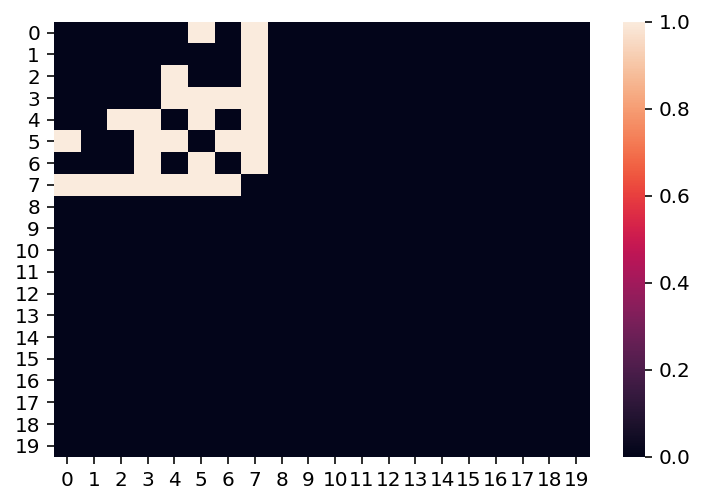

In [11]:
import seaborn as sns

sns.heatmap(train_graph[0][0].squeeze())

In [15]:
train_graph[0].shape

(253, 20, 20, 1)

In [18]:
from patch_gnn.layers import GraphAttention
from jax import vmap
from functools import partial

init_fun, apply_fun = GraphAttention(n_output_dims=128)

output_shape, params = init_fun(key, input_shape=(20, 67, 1))

out = vmap(partial(apply_fun, params))(train_graph)
out.shape

(253, 20, 128)

Notes to self:|

1. Input shape is always `(-1, n_node_feats)`.
2. Always vmap the `apply_fun`!!!!!

## Custom models

In [19]:
from patch_gnn.layers import GraphSummation
model_init_fun, model_apply_fun = stax.serial(
    GraphAttention(n_output_dims=128),
    GraphSummation(),
    stax.Dense(128),
    stax.Relu,
    stax.Dense(1),
)

In [21]:
output_shape, params = model_init_fun(key, input_shape=(20, 67, 1))
output = vmap(partial(model_apply_fun, params))(train_graph)

In [22]:
output.shape

(253, 1)

In [1]:
from patch_gnn.models import DeepGAT

In [2]:
model = DeepGAT(node_feature_shape=(20, 67), num_adjacency=1, num_training_steps=500)

In [3]:
from patch_gnn.layers import concatenate_node_features, node_attention

attentions, output = vmap(partial(node_attention, model.params[0]))(train_graph)
sns.heatmap(attentions[0])

NameError: name 'vmap' is not defined

In [28]:
model.fit(train_graph, train_target)

  0%|          | 0/500 [00:00<?, ?it/s]

In [29]:
checkpoint = -1
preds = model.predict(test_graph, checkpoint=checkpoint)

In [30]:
import matplotlib.pyplot as plt

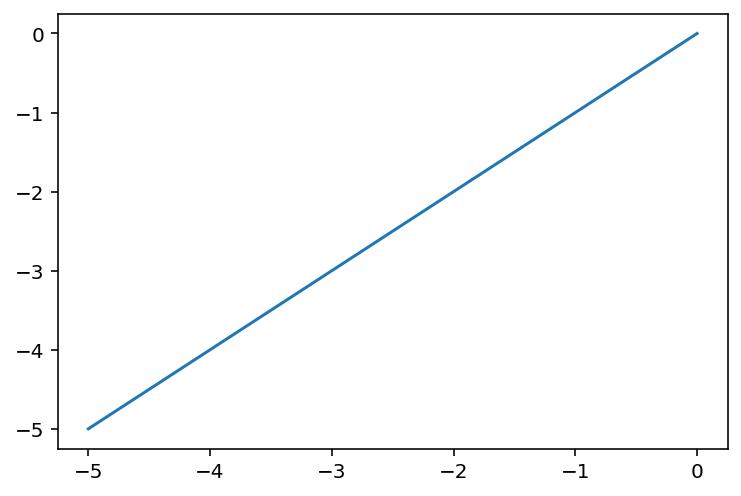

In [31]:
plt.scatter(test_target.squeeze(), preds.squeeze())
plt.plot([-5, 0], [-5, 0])

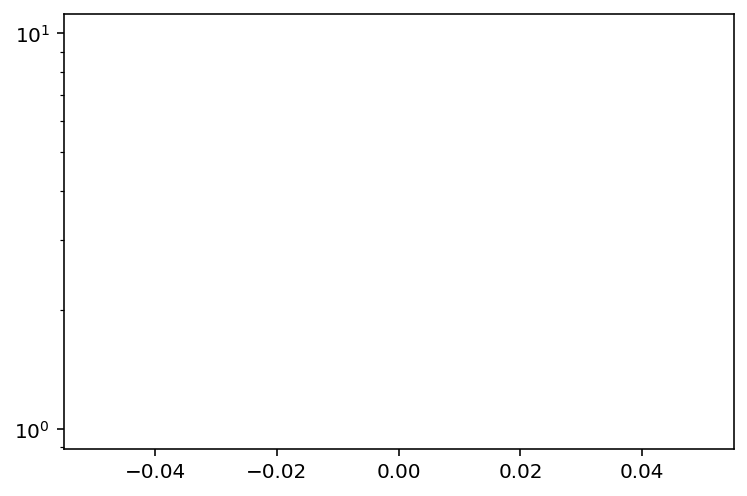

In [32]:
plt.plot(model.loss_history)
plt.yscale("log")

In [33]:
train_preds = model.predict(train_graph, checkpoint=checkpoint)

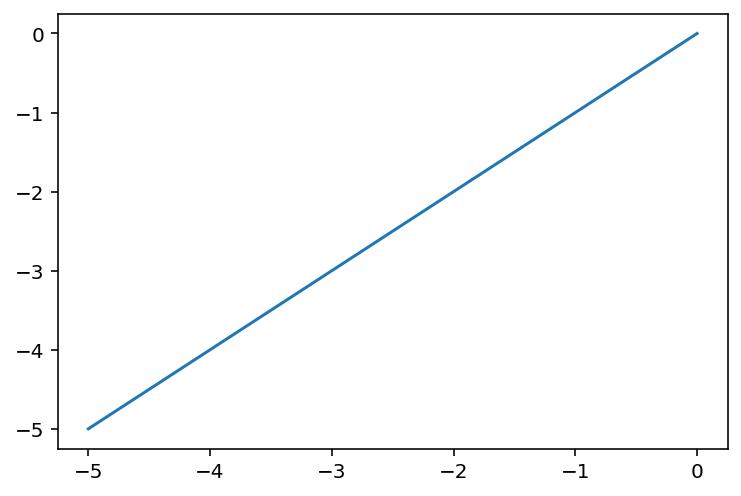

In [34]:
plt.scatter(train_target.squeeze(), train_preds.squeeze())
plt.plot([-5, 0], [-5, 0])

In [35]:
from sklearn.metrics import explained_variance_score as evs, r2_score as r2

In [36]:
from tqdm.auto import tqdm
from jax import jit
def learning_curves(model, data, score_func, *, interval: int=20):
    X, y = data
    scores = []
    for i in tqdm(range(len(model.loss_history))[::interval]):
        preds = model.predict(X, checkpoint=i)
        score = score_func(y.squeeze(), preds.squeeze())
        scores.append(score)
    return scores

In [37]:
interval = 5
train_score = learning_curves(model, (train_graph, train_target), r2, interval=interval)
test_score = learning_curves(model, (test_graph, test_target), r2, interval=interval)

  0%|          | 0/100 [00:00<?, ?it/s]

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## Learning curve with epochs

In [38]:
plt.plot(train_score)
plt.plot(test_score)
plt.xlabel(f"Training steps divided by {interval}")
plt.ylabel("score")
plt.title("r2")


NameError: name 'train_score' is not defined

In [39]:
r2(train_target.squeeze(), train_preds.squeeze())

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
r2(test_target.squeeze(), preds.squeeze())

## Explore what's learned by GATs

Per-graph, what is the attention matrix like.

In [ ]:
import jax.numpy as np
from patch_gnn.layers import concatenate_node_features, node_attention
from jax import nn

In [ ]:
train_df.query("ox_fwd_logit > -0.5")

In [ ]:
idx = list(train_df.index).index(2297)

In [ ]:
row = train_df.iloc[idx]
row["ox_fwd_logit"]

In [ ]:
g_key = row["accession-sequence"]
g_key

In [ ]:
g = graphs[g_key]
g.nodes()

In [ ]:
g.nodes(data=True)

In [ ]:
import pandas as pd

aa_props = pd.read_csv(here() / "data/amino_acid_properties.csv", index_col=0)

In [ ]:
index = list(aa_props.index)
index.extend(["Phob", "Phil", "SASA", "N"])

In [ ]:
pd.Series(dict(zip(index, np.abs(model.params[0][2])))).sort_values().to_dict()

In [ ]:
import seaborn as sns
attentions, output = vmap(partial(node_attention, model.params[0]))(train_graph)
ax = sns.heatmap(attentions[idx][0:len(g.nodes()), 0:len(g.nodes())], cmap="viridis")
ax.set_xticklabels(list(g.nodes()), rotation = 90)
ax.set_yticklabels(list(g.nodes()), rotation = 0)
attentions.shape

The vertical numbers are not all identical. Keep that in mind.

In [ ]:
import networkx as nx
nx.draw(g, with_labels=True)

# GRAVEYARD

In [ ]:
from patch_gnn.layers import normalize_if_nonzero
from jax import grad

In [ ]:
normalize_if_nonzero(p_vect=np.zeros(3))

In [ ]:
a = np.array([0.1, 0.5, 0.0])
normalize_if_nonzero(p_vect=a)

In [ ]:
def f(p):
    p = normalize_if_nonzero(p)
    return np.sum(p)

In [ ]:
f(np.)

In [ ]:
df = grad(f)

In [ ]:
df(np.zeros(3)),  df(a)